# Naïve Bayes Classifier - Spam detection

We've found several resources on the web, articles etc. that tend to indicate that the Nïve bayes classifier especially is very performant for spam detection. We'll be trying this additionnal model on the information we gathered through NLP, that is to say our word count and TF-IDF matrix scores rahter than on features we've found previously for our XGBoost program. Comparing the two models will not only allow us to benchmark our model but also check the scalability of it.

In [47]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

ModuleNotFoundError: No module named 'sklearn.cross_validation'

## 1. Loading the data

We will be directly working on the data that was preprocessed in our first notebook

In [2]:
data = pd.read_csv('spam_data_full.csv',index_col=0)
X = data['sms']
y = data['class']

We can already create our test/train split on which we will work (80-20 in this case)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Pre - Processing the data 

### A. Stopwords and punctiation

We aren't applying the same punctuation filter given that some special characters might be of interest (repetitive question and exclamation marks, dollar signs etc.)

In [4]:
def clean_text(text):
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='"\'%&()*,-./:;<=>?[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

Concerning stopwords, we'll take care of them later on.

## 3.Vectorization

There are various NLP methods that can be usefull for classification, one of them is vectorization. Basically it's a word count per sms that the model will process to distinguish ham from spam. We'll explore later on other options as this method has some drawbacks. Namely the problem with wordcount is that it is subject to the length of the sms and we saw in our EDA that this could be a noteable feature for distinguishing the two classes. Nonetheless we will still try it out and check our results afterwards.

**A slight modification is necessary just below to switch between vectorization and TF-IDF!**

/Users/laks/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


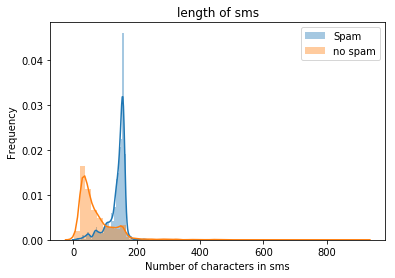

In [5]:
#spam:
ind = data.loc[:,"class"]==1
data_spam=data[ind]
sns.distplot(data_spam.loc[:,'length'],label="Spam")

#not spam:
data_ham=data[-ind]
ax = sns.distplot(data_ham.loc[:,'length'],label="no spam")
plt.legend()
plt.title('length of sms')
ax.set(xlabel='Number of characters in sms', ylabel='Frequency')
plt.show()

##### We intialize the vectorizer giving him the paramters we defined for pre processing that we will apply on our test and train data. Note that the stopwords are applied here.

###  - For simple vectorization:

* Initialize the vectorizer

In [6]:
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text)

* Train/Test formatting

Note that we are not fitting the testing data in the vectorizer!

In [7]:
data_train_count = vectorizer.fit_transform(X_train)
data_test_count = vectorizer.transform(X_test)

### - For TF-IDF scores:

* Initialize the vectorizer

In [8]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text)

* Train/Test formatting

Note that we are not fitting the testing data in the vectorizer!

In [9]:
data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

## 4. Building the model

The miracles of scikit-learn! 

#### - Fitting a model for count vectorization

* Model fit

In [10]:
clf_count = MultinomialNB()
clf_count.fit(data_train_count,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

* Predicting on test data

In [40]:
pred_count = clf_count.predict(data_test_count)
pred_count_prob = clf_count.predict_proba(data_test_count)[:,1]

#### - Fitting a model for TF-IDF vectorization

* Model fit

In [12]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(data_train_tfidf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

* Predicting on test data

In [41]:
pred_tfidf = clf_tfidf.predict(data_test_tfidf)
pred_count_tfidf = clf_tfidf.predict_proba(data_test_tfidf)[:,1]

## 5. Model evaluation

Accuracy (ratio of correct predicitons) : # correct predictions / # total predictions


Precision (proportion of messages classified as spam which were spam) : # True positives / # (True positives + False positives)

Sensitivity ()

#### - Count vectorization results

In [14]:
print("\n")
print("Using count vectorization")
print("\n")
acc_count = accuracy_score(y_test,pred_count)
prec_count = precision_score(y_test, pred_count)
sens_count = recall_score(y_test,pred_count)

print("Accuracy :", acc_count)
print("Precision :", prec_count)
print("Sensitivity :", sens_count)



Using count vectorization


Accuracy : 0.9847533632286996
Precision : 0.9615384615384616
Sensitivity : 0.9316770186335404


In [34]:
confusion = metrics.confusion_matrix(y_test, pred_count)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("\n")
print("We correctly classified",TP,"sms as spam")
print("\n")
print("We correctly classified ",TN," sms as not spam")
print("\n")
print("We inccorrectly classified ",FP," sms as spam")
print("\n")
print("We inccorrectly classified ",FN," sms as not spam")

[[948   6]
 [ 11 150]]


We correctly classified 150 sms as spam


We correctly classified  948  sms as not spam


We inccorrectly classified  6  sms as spam


We inccorrectly classified  11  sms as not spam


AUC score : 0.988121280779197




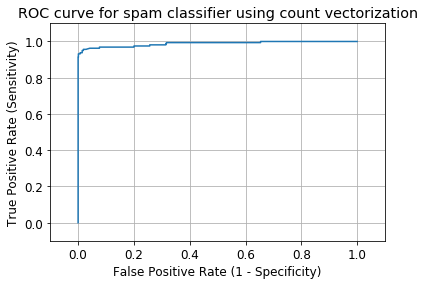

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_count_prob)

plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for spam classifier using count vectorization')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("AUC score :",metrics.roc_auc_score(y_test, pred_count_prob))
print("\n")

#### - TF-IDF vectorization results

In [15]:
print("\n")
print("Using TF-IDF vectorization")
print("\n")

acc_tfidf = accuracy_score(y_test,pred_tfidf)
prec_tfidf = precision_score(y_test, pred_tfidf)
sens_tfidf = recall_score(y_test,pred_tfidf)

print("Accuracy :", acc_tfidf)
print("Precision :", prec_tfidf)
print("Sensitivity :", sens_tfidf)



Using TF-IDF vectorization


Accuracy : 0.9739910313901345
Precision : 1.0
Sensitivity : 0.8198757763975155


In [35]:
confusion = metrics.confusion_matrix(y_test, pred_tfidf)
print(confusion)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("\n")
print("We correctly classified",TP,"sms as spam")
print("\n")
print("We correctly classified ",TN," sms as not spam")
print("\n")
print("We inccorrectly classified ",FP," sms as spam")
print("\n")
print("We inccorrectly classified ",FN," sms as not spam")

[[954   0]
 [ 29 132]]


We correctly classified 132 sms as spam


We correctly classified  954  sms as not spam


We inccorrectly classified  0  sms as spam


We inccorrectly classified  29  sms as not spam


AUC score : 0.9886160917744182




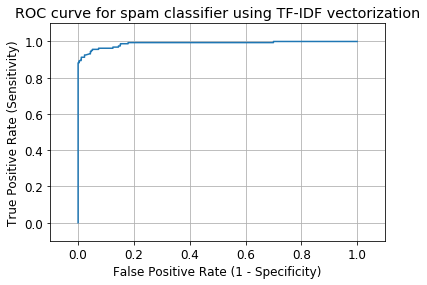

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_count_tfidf)

plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for spam classifier using TF-IDF vectorization')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print("AUC score :",metrics.roc_auc_score(y_test, pred_count_tfidf))
print("\n")

In [16]:
print("you can merge!")

you can merge!
